## Analytic solutions for isoviscous convection 

In the third notebook in this tutorial we use an analytic model for the gravity field due to both internal density anomalies as well as dynamic topography on the model surface and model base. There is a linear relationship* between the gravity anomaly and the surface dynamic topography. However, the surface gravity anomaly due to the dynamic topgraphy at the base of the model depends on the wavenumber and the depth. This contrubution can be __upward continued__ - exactly like the internal density anamalies (mass sheets) are treated. 

The analytic model comes from _The relationship between surface topography, gravity anomalies, and temperature structure of convection._ Parsons, Barry, and Stephen Daly. Journal of Geophysical Research: Solid Earth 88.B2 (1983): 1129-1144.


Assume a vertical temperature structure of $sin (\pi z)$, and a spectral density structure ( a sum of different modes). The non-dimensional gravity can be written:

$$ g' = \xi + \zeta \exp(-k) - \frac{\pi(1 + \exp(-k))}{(\pi^2 + k^2)} $$



The three contributing terms, in order, are the surface dynamic topography, the base dynamic topography and the internal density structure. $k$ is tha angular wavenumber. In the case of rigid (free-slip) boundaries:

$$ \xi = \zeta = \frac{(\pi^3 + 3\pi k)}{(\pi^2 + k^2)^2}$$

*Note that the non-dimensionlisation prodeedure implicit in this solution means that the dimensionless gravity contribution from the surface dynamic topography is equal to the dimensionless surface stress. Hence, we will compare the predicted values of $\xi$, to the total stress at the surface in the numerical models:

$$ \sigma_{zz} = - P + 2\eta\frac{\partial{u_z}}{\partial{z}} \equiv \xi $$


## To do




* sign of gravity
* get rid of eval points

In [105]:
import underworld as uw
from underworld import function as fn
import glucifer
from scipy.integrate import simps, trapz
import numpy as np
from spectral_tools import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [106]:
# first create a mesh and variable
mesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                elementRes=(128,128),
                                minCoord    = (0, 0), 
                                maxCoord    = (1, 1.) )


tempVar = uw.mesh.MeshVariable(mesh,1)

## Create a temperature field for a set of wavenumber and random amplitudes

In [107]:
#Produce a random set of amplitues for nk wavenumbers 

nk = 5
np.random.seed(5)
amps = np.random.rand(nk - 1) 
x = fn.coord()[0]
y = fn.coord()[1]
modes = []
ks = []
for i in range(1,nk):
    print(i)
    factor = float(i)*2.*np.pi
    ks.append(factor)
    modes.append(factor*x
                )
    
#cosfns = fn.math.cos(modes)
cosfns = fn.math.dot(amps, fn.math.cos(modes))

zFn = 1. - fn.coord()[1]
verticalTemp =  fn.math.sin(np.pi*zFn)
TzFns = np.ones(nk)


#final temperature is the outer product of the horizontal modes and the vertical temp structure
tempFn = fn.math.dot(cosfns,TzFns )
tempFn = tempFn*verticalTemp
tempVar.data[:] = tempFn.evaluate(mesh)

1
2
3
4



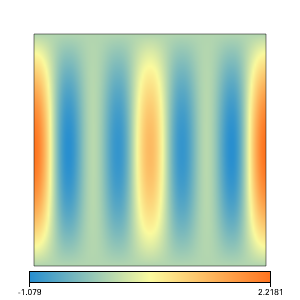

In [108]:
fig = glucifer.Figure(quality=3, figsize=(300,300))
fig.append( glucifer.objects.Surface(mesh,tempVar, onMesh=True) )
fig.show()

## Build the Parsons and Daly solutions

$$ g' = A_k\left(\xi + \zeta \exp(-k) - \frac{\pi(1 + \exp(-k))}{(\pi^2 + k^2)} \right)$$

Note that we have includes a random amplitude for each mode ($A_k$).

In [109]:
xVals = np.linspace(0., 1., 100)

######################
#Temperature component
######################

ks = np.array(ks) 
#amplitudes of the different modes
gravTemp_k = amps*(np.pi*(1. + np.exp(-1.*ks)))/(np.pi**2 + ks**2)


#now do the fourier synthesis
gravComps = []
for i in range(0,nk - 1):
    gravComps.append(gravTemp_k[i] *np.cos(ks[i]*xVals))
    
gravTemp = np.array(gravComps).sum(axis=0)

######################
#Surface dyn. topography component
######################

gravSurf_k = amps*(np.pi**3 + 3*np.pi*ks**2)/((np.pi**2 + ks**2 )**2) 


surfComps = []
for i in range(0,nk - 1):    
    surfComps.append(gravSurf_k[i] *np.cos(ks[i]*xVals))
    
gravSurf = np.array(surfComps).sum(axis=0)


######################
#Base. dyn. topography component
######################

upContFac = np.exp(-1.*ks)
gravBase_k = upContFac*amps*(np.pi**3 + 3*np.pi*ks**2)/((np.pi**2 + ks**2 )**2) 


baseComps = []
for i in range(0,nk - 1):    
    baseComps.append(gravBase_k[i] *np.cos(ks[i]*xVals))
    
gravBase = np.array(baseComps).sum(axis=0)


## Underworld2 Stokes solution and surface stress

In [110]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0

# Construct our density function.
densityFn = Ra * tempVar

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

In [111]:
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )


velocityField.data[:] = 0.
pressureField.data[:] = 0.

In [112]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]

In [113]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )



In [114]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

In [115]:
solver.solve()


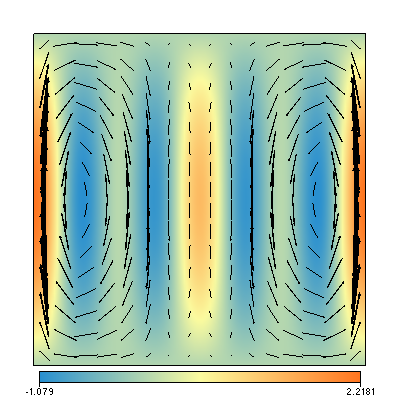

In [116]:
# plot figure
figtemp = glucifer.Figure( figsize=(400,400) )
figtemp.append( glucifer.objects.Surface(mesh, tempVar, onMesh=True) )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField*30.) )
figtemp.show()

In [117]:
## Surface stress

devStressFn =  2.*stokes.fn_viscosity*fn.tensor.symmetric( velocityField.fn_gradient ) #- pressureField
devStressField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=3 )
projectorDevStress = uw.utils.MeshVariable_Projection( devStressField, devStressFn , type=0 )
projectorDevStress.solve()


meshPressure = uw.mesh.MeshVariable( mesh, 1 )
projectorPressure = uw.utils.MeshVariable_Projection( meshPressure, pressureField, type=0 )
projectorPressure.solve()

#total stress
totalStressFn = -1.*(devStressField[1] - meshPressure)

## Compare analytic & numeric solutions for surface stress (gravity)

There is no wavenumber dependence for the gravity anomaly contribution due to the surface dynamic topography. So we simply need to extract the Underworld stress at the surface. 

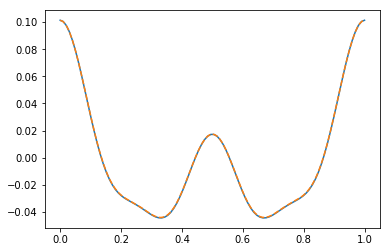

In [118]:
meshxs = mesh.data[tWalls.data][:,0]

fig, ax = plt.subplots()

gravSurfNumeric = totalStressFn.evaluate(mesh.data[tWalls.data])

ax.plot(xVals, gravSurf - gravSurf.mean())
ax.plot(meshxs, gravSurfNumeric - gravSurfNumeric.mean(), ls = '--' )


## Underworld Spectral integral for density anomaly due to temperature

In [119]:
modeOvershot = 3  #check if there is any mode leakage

ks = integral_wavenumbers(mesh, nk + modeOvershot, axisIndex=1)
upContKernelFn = fn.math.exp(-1.*(1. - fn.coord()[1])*ks)


In [120]:
synthFn, coeffs = spectral_integral(mesh, tempVar, N=nk + modeOvershot, axisIndex=1, kernelFn=upContKernelFn, 
                                    average = True, integrationType="volume",surfaceIndexSet=None, returnCoeffs=True )

In [121]:
meshxs= mesh.data[mesh.specialSets['MaxJ_VertexSet'].data][:,0]

evalPoints= np.column_stack( (meshxs, np.ones(len(meshxs)) ))
gravTempNumeric  = synthFn.evaluate(evalPoints )


In [122]:
#gravTempUw.mean()

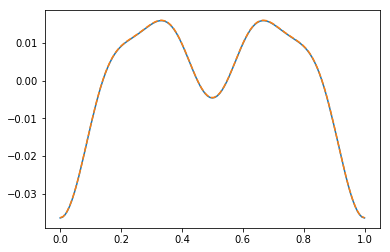

In [123]:
plt.plot(meshxs, -1.*(gravTempNumeric  - gravTempNumeric.mean()) )
plt.plot(xVals, -1.*(gravTemp - gravTemp.mean()), ls = '--')

In [124]:
## Now the Basal Stress
synthFn2  = spectral_integral(mesh, totalStressFn, N=nk +modeOvershot, axisIndex=1, kernelFn=upContKernelFn, average = True, 
                      integrationType="surface",surfaceIndexSet=mesh.specialSets['MinJ_VertexSet'], returnCoeffs=False )

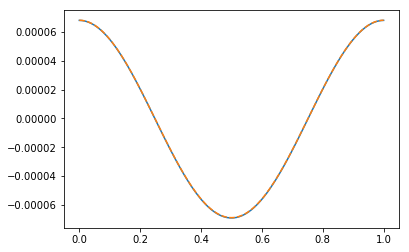

In [125]:
gravBaseNumeric =  synthFn2.evaluate(evalPoints)


fig, ax = plt.subplots()


ax.plot(xVals, gravBase- gravBase.mean(), ls = '-')
ax.plot(meshxs, -1.*(gravBaseNumeric- gravBaseNumeric.mean()), ls = '--' )


## Total Gravity

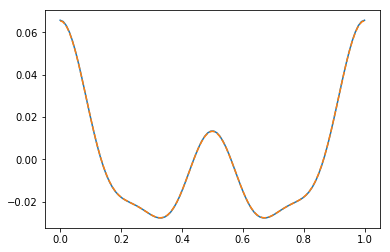

In [126]:
gravNumTotal = gravSurfNumeric - gravBaseNumeric - gravTempUw
gravAnTotal = gravSurf + gravBase - gravTemp


fig, ax = plt.subplots()
ax.plot(xVals, gravAnTotal)
ax.plot(meshxs, gravNumTotal, ls = '--' )

## Plot the amplitudes of the differnet modes in the temperature (density) integral

In [127]:

sincfs = coeffs[0].evaluate()
coscfs = coeffs[1].evaluate()

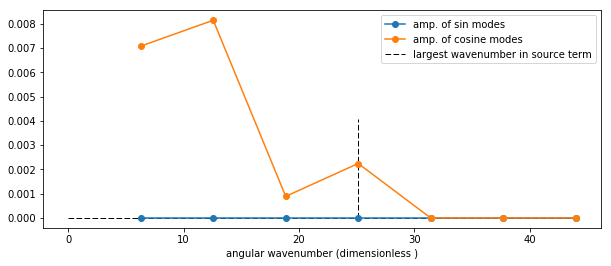

In [138]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(ks,sincfs ,label = 'amp. of sin modes', marker='o'  )
ax.plot(ks,coscfs, label = 'amp. of cosine modes' , marker='o' )
ax.legend()
ax.hlines(0,0, ks[-1], linestyles='--', lw=1. )
ax.set_xlabel('angular wavenumber (dimensionless )')

ax.vlines(ks[nk - 2],0, 0.5*max(coscfs), linestyles='--', lw=1., label ='largest wavenumber in source term' )

ax.legend()